# Maps of molecular gas around 30 Dor

We want to compare the distribution of molecular gas with that of the Raman wings. 

Mabel is going to be doing most of that, but here I am going to create some integrated line maps from the original data cubes obtained from observatory archives.

In [110]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy import constants
from reproject import reproject_interp

## Alma maps of 30 Dor-10 GMC

These maps are described in [Indebetouw et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...888...56I).



In [2]:
DATAPATH = Path.cwd().parent / "big-data" / "30-Dor-Radio"

In [3]:
DATAPATH

PosixPath('/Users/will/Dropbox/muse-hii-regions/big-data/30-Dor-Radio')

In [4]:
PATH_2013 = DATAPATH / "2013.1.00346.S/science_goal.uid___A001_X12a_X279/group.uid___A001_X12a_X27a/member.uid___A001_X12a_X27b/product"

In [5]:
hdulist = fits.open(PATH_2013 / "member.uid___A001_X12a_X27b.30_doradus_13CO21.image.fits")

In [6]:
hdulist.info()

Filename: /Users/will/Dropbox/muse-hii-regions/big-data/30-Dor-Radio/2013.1.00346.S/science_goal.uid___A001_X12a_X279/group.uid___A001_X12a_X27a/member.uid___A001_X12a_X27b/product/member.uid___A001_X12a_X27b.30_doradus_13CO21.image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     590   (2500, 2000, 56, 1)   float32   


In [7]:
w = WCS(hdulist["PRIMARY"].header)

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

In [8]:
w.celestial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 84.70522916667  -69.07888555556  
CRPIX : 1251.0  1001.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -8.888888888889e-06  8.888888888889e-06  
NAXIS : 2500  2000

The original data has 4 axes (4th is degenerate axis of Stokes parameters).  So, we have to sum over 2 axes to get down to the pure image.

In [9]:
image = np.nansum(
    hdulist["PRIMARY"].data,
    axis=(0, 1),
)
image.shape

(2000, 2500)

Now write out the image with a new header:

In [10]:
fits.PrimaryHDU(
    header=w.celestial.to_header(),
    data=image,
).writeto(
    DATAPATH / "Alma-2013.1.00346.S-30_doradus_13CO21-sum.fits",
    overwrite=True,
)

In [11]:
image = np.nanmax(
    hdulist["PRIMARY"].data,
    axis=(0, 1),
)
fits.PrimaryHDU(
    header=w.celestial.to_header(),
    data=image,
).writeto(
    DATAPATH / "Alma-2013.1.00346.S-30_doradus_13CO21-peak.fits",
    overwrite=True,
)

<ipython-input-11-baf7799f674b>:1: RuntimeWarning: All-NaN slice encountered
  image = np.nanmax(


## The 2019 Alma observations from the `2019.1.00843.S` program

In [12]:
RAW_DATAPATH = Path.home() / "Work"/ "Alma-Data" / "LMC-30-Dor"

In [13]:
def fitspath(uid: str, spw: int=25):
    """Find an ALMA spectral cube file with given `uid`"""
    filename = f"member.uid___A001_X1465_X{uid}.30_Doradus_sci.spw{spw}.cube.I.pbcor.fits"
    matches = list(RAW_DATAPATH.rglob(filename))
    assert len(matches) == 1
    return matches[0]

Check that we can find a cube:

In [14]:
fitspath("219a")

PosixPath('/Users/will/Work/Alma-Data/LMC-30-Dor/2019.1.00843.S/science_goal.uid___A001_X1465_X2198/group.uid___A001_X1465_X2199/member.uid___A001_X1465_X219a/product/member.uid___A001_X1465_X219a.30_Doradus_sci.spw25.cube.I.pbcor.fits')

In [42]:
list(RAW_DATAPATH.rglob("*30_Doradus_sci.spw29.cube.I.pbcor.fits"))

[PosixPath('/Users/will/Work/Alma-Data/LMC-30-Dor/2019.1.00843.S/science_goal.uid___A001_X1465_X2198/group.uid___A001_X1465_X2199/member.uid___A001_X1465_X219a/product/member.uid___A001_X1465_X219a.30_Doradus_sci.spw29.cube.I.pbcor.fits'),
 PosixPath('/Users/will/Work/Alma-Data/LMC-30-Dor/2019.1.00843.S/science_goal.uid___A001_X1465_X2190/group.uid___A001_X1465_X2191/member.uid___A001_X1465_X2192/product/member.uid___A001_X1465_X2192.30_Doradus_sci.spw29.cube.I.pbcor.fits'),
 PosixPath('/Users/will/Work/Alma-Data/LMC-30-Dor/2019.1.00843.S/science_goal.uid___A001_X1465_X2188/group.uid___A001_X1465_X2189/member.uid___A001_X1465_X218a/product/member.uid___A001_X1465_X218a.30_Doradus_sci.spw29.cube.I.pbcor.fits')]

In [44]:
uids = ["218a", "2192", "219a"]
paths_12co = {uid: fitspath(uid) for uid in uids}
paths_13co = {uid: fitspath(uid, spw=29) for uid in uids}

In [74]:
for p in paths_13co.values():
    fits.open(p).info()

Filename: /Users/will/Work/Alma-Data/LMC-30-Dor/2019.1.00843.S/science_goal.uid___A001_X1465_X2188/group.uid___A001_X1465_X2189/member.uid___A001_X1465_X218a/product/member.uid___A001_X1465_X218a.30_Doradus_sci.spw29.cube.I.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     109   (720, 700, 1916, 1)   float32   
Filename: /Users/will/Work/Alma-Data/LMC-30-Dor/2019.1.00843.S/science_goal.uid___A001_X1465_X2190/group.uid___A001_X1465_X2191/member.uid___A001_X1465_X2192/product/member.uid___A001_X1465_X2192.30_Doradus_sci.spw29.cube.I.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     109   (750, 750, 1916, 1)   float32   
Filename: /Users/will/Work/Alma-Data/LMC-30-Dor/2019.1.00843.S/science_goal.uid___A001_X1465_X2198/group.uid___A001_X1465_X2199/member.uid___A001_X1465_X219a/product/member.uid___A001_X1465_X219a.30_Doradus_sci.spw29.cube.I.pbcor.fits
No.    Name      Ver 

Function to calculate the velocity moments of a cube:

In [65]:
def moments(cube, vels):
    vcube = vels[:, None, None]
    mom0 = np.nansum(cube, axis=0)
    mom1 = np.nansum(cube * vcube, axis=0)
    vmean = mom1 / mom0
    mom2 = np.nansum(cube * (vcube - vmean)**2, axis=0)
    sigma = np.sqrt(mom2 / mom0)
    return mom0, vmean, sigma

Use the rest frequency in the header to convert the spectral axis to velocity, remembering that all must be in SI units.  Then, make an array of velocities in km/s for the spectral axis

In [66]:
def get_velocities(hdu):
    hdr = hdu.header.copy()
    # Rest frequency
    nu0 = hdr["RESTFRQ"] * u.Hz
    # Frequency of reference pixel
    nu1 = hdr["CRVAL3"] * u.Hz
    # Change from frequency to "Radio" velocities
    hdr["CTYPE3"] = "VRAD"
    hdr["CRVAL3"] = (constants.c * (nu0 - nu1) / nu0).si.value
    hdr["CDELT3"] *= -(1.0 * u.Hz * constants.c / nu0).si.value
    hdr["CUNIT3"] = "m/s"
    wspec = WCS(hdr).spectral
    
    ns, nv, ny, nx = hdu.data.shape
    vels = wspec.array_index_to_world(
        np.arange(nv)
    ).to(u.km / u.s).value
    return vels

This does a rolling average over the velocity axis, so that we get less noise in the "max" maps.  We are fine doing this because the velocity pixel size is much smaller than the effective velocity resolution. 

In [98]:
def smooth_vels(cube, n):
    "Perform rolling average of length `n` along the 0-th axis"
    kernel = np.ones(n) / n
    nv, ny, nx = cube.shape
    for j, i in np.ndindex(ny, nx):
        cube[:, j, i] = np.convolve(cube[:, j, i], kernel, mode="same")
    return cube

In [100]:
def get_moments_and_spectrum(hdu, klim=(700, 1400)):
    k1, k2 = klim
    vels = get_velocities(hdu)
    full_cube = hdu.data[0, ...]
    zoom_cube = full_cube[k1:k2, ...]
    _sum, vmean, sigma = moments(zoom_cube, vels[k1:k2])
    peak = np.nanmax(full_cube, axis=0)
    peak04 = np.nanmax(smooth_vels(full_cube, 4), axis=0)
    peak08 = np.nanmax(smooth_vels(full_cube, 8), axis=0)
    spec = np.nansum(full_cube, axis=(1, 2))
    specm = np.nanmax(full_cube, axis=(1, 2))
    return {
        "vels": vels,
        "spec": spec,
        "specm": specm,
        "peak": peak,
        "peak04": peak04,
        "peak08": peak08,
        "sum": _sum,
        "vmean": vmean,
        "sigma": sigma,
        "wcs": WCS(hdu.header).celestial,
        "hdu": hdu,
        "klim": klim,
    }

Save a peak and a mean version of each map.  Also, keep a dict `cubes_12co` of the original cubes for later use. 

In [101]:
data_12co = {
    uid: get_moments_and_spectrum(fits.open(p)["PRIMARY"])
    for uid, p in paths_12co.items()
}

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
<ipython-input-65-de6245f69a3e>:5: RuntimeWarning: invalid value encountered in true_divide
  vmean = mom1 / mom0
<ipython-input-65-de6245f69a3e>:7: RuntimeWarning: invalid value encountered in true_divide
  sigma = np.sqrt(mom2 / mom0)
<ipython-input-65-de6245f69a3e>:7: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(mom2 / mom0)
<ipython-input-100-052ec022d8cd>:7: RuntimeWarning: All-NaN slice encountered
  peak = np.nanmax(full_cube, axis=0)
<ipython-input-100-052ec022d8cd>:8: RuntimeWarning: All-NaN slice encountered
  peak04 = np.nanmax(smooth_vels(full_cube, 4), axis=0)
<ipython-input-100-052ec022d8cd>:9: RuntimeWarning: All-NaN slice encountered
  peak08 = np.nanmax(smooth_vels(full_cube, 8), axis=0)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from

In [107]:
data_13co = {
    uid: get_moments_and_spectrum(fits.open(p)["PRIMARY"])
    for uid, p in paths_13co.items()
}

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
<ipython-input-65-de6245f69a3e>:5: RuntimeWarning: invalid value encountered in true_divide
  vmean = mom1 / mom0
<ipython-input-65-de6245f69a3e>:7: RuntimeWarning: invalid value encountered in true_divide
  sigma = np.sqrt(mom2 / mom0)
<ipython-input-65-de6245f69a3e>:7: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(mom2 / mom0)
<ipython-input-100-052ec022d8cd>:7: RuntimeWarning: All-NaN slice encountered
  peak = np.nanmax(full_cube, axis=0)
<ipython-input-100-052ec022d8cd>:8: RuntimeWarning: All-NaN slice encountered
  peak04 = np.nanmax(smooth_vels(full_cube, 4), axis=0)
<ipython-input-100-052ec022d8cd>:9: RuntimeWarning: All-NaN slice encountered
  peak08 = np.nanmax(smooth_vels(full_cube, 8), axis=0)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from

In [104]:
PREFIX = "Alma-2019.1.00843.S-30_doradus"
def save_images(data_dict, line_id="12CO21"):
    for uid, data in data_dict.items():
        w = data["wcs"]
        for label in "peak", "peak04", "peak08", "sum", "vmean", "sigma":
            image = data[label]
            savepath = DATAPATH / f"{PREFIX}_{line_id}-{uid}-{label}.fits"
            fits.PrimaryHDU(
                header=w.to_header(), 
                data=image,
            ).writeto(savepath, overwrite=True)

Save all the maps to fits files.

In [105]:
save_images(data_12co, line_id="12CO21")

In [108]:
save_images(data_13co, line_id="13CO21")

### Stitch together the images

Regrid everything to the MUSE frame and then take the median (or the minimum for the max images). 

In [111]:
MUSE_DATAPATH = Path.cwd().parent / "data" 
musefile = "lmc-30dor-ABCD-oiii-4959-bin01-sum.fits"
musehdu = fits.open(MUSE_DATAPATH / musefile)["DATA"]

In [112]:
WCS(musehdu.header)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 84.688309  -69.105970125  
CRPIX : 220.92793852  213.660785628  
CD1_1 CD1_2  : -5.52742276729e-05  -9.66418424553e-08  
CD2_1 CD2_2  : -4.91681964084e-07  5.53153613478e-05  
NAXIS : 650  650

In [122]:
images = [
    reproject_interp((db["peak08"], db["wcs"]), musehdu.header, return_footprint=False)
    for db in data_12co.values()
]

<ipython-input-126-1367de3a2b25>:1: RuntimeWarning: All-NaN slice encountered
  im = np.nanmin(


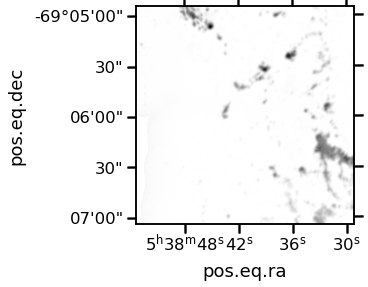

In [126]:
im = np.nanmin(
    np.stack(images),
    axis=0,
)
#im[~np.isfinite(im)] = 0.0
fig, ax = plt.subplots(subplot_kw=dict(projection=WCS(musehdu.header)))
ax.imshow(
    im, 
#     vmin=0.0, 
#     vmax=2.11,
    cmap="gray_r",
)
ax.set_aspect("equal")

This looks good.  Now write to file.

In [129]:
fits.PrimaryHDU(
    header=musehdu.header,
    data=im,
).writeto(MUSE_DATAPATH / "lmc-30dor-ABCD-12co-21-reproject-max.fits")

Repeat for 13CO

In [130]:
images = [
    reproject_interp((db["peak08"], db["wcs"]), musehdu.header, return_footprint=False)
    for db in data_13co.values()
]
im = np.nanmin(
    np.stack(images),
    axis=0,
)
fits.PrimaryHDU(
    header=musehdu.header,
    data=im,
).writeto(
    MUSE_DATAPATH / "lmc-30dor-ABCD-13co-21-reproject-max.fits", 
    overwrite=True,
)

<ipython-input-130-09b454ee40e6>:5: RuntimeWarning: All-NaN slice encountered
  im = np.nanmin(


And repeat for the summed intensity and the velocity moments:

In [147]:
for line_id, dbdict in [["13co", data_13co], ["12co", data_12co]]:
    for db in dbdict.values():
        missing_mask = db["sum"] == 0.0
        db["sum"][missing_mask] = np.nan
    imstack = {}
    for q in "peak08", "sum", "vmean", "sigma":
        imstack[q] = np.stack([
            reproject_interp(
                (db[q], db["wcs"]), 
                musehdu.header, 
                return_footprint=False,
            )
            for db in dbdict.values()
        ])
    peak = np.nanmin(imstack["peak08"], axis=0)
    mom0 = np.nanmean(imstack["sum"], axis=0)
    mom1 = np.nanmean(imstack["sum"] * imstack["vmean"], axis=0)
    mom2 = np.nanmean(imstack["sum"] * imstack["sigma"] ** 2, axis=0)
    vmean = mom1 / mom0
    sigma = np.sqrt(np.abs(mom2 / mom0))
    weak_mask = (peak <= 0.15) & (mom0 < 10.0)
    vmean[weak_mask] = np.nan
    sigma[weak_mask] = np.nan
    for im, label in [
        [mom0, "sum"], 
        [peak, "peak"], 
        [vmean, "vmean"], 
        [sigma, "sigma"]
    ]:
        fits.PrimaryHDU(
            header=musehdu.header,
            data=im,
        ).writeto(
            MUSE_DATAPATH / f"lmc-30dor-ABCD-{line_id}-21-reproject-{label}.fits", 
            overwrite=True,
        )
                 

<ipython-input-147-f6cf024a1074>:15: RuntimeWarning: All-NaN slice encountered
  peak = np.nanmin(imstack["peak08"], axis=0)
<ipython-input-147-f6cf024a1074>:16: RuntimeWarning: Mean of empty slice
  mom0 = np.nanmean(imstack["sum"], axis=0)
<ipython-input-147-f6cf024a1074>:17: RuntimeWarning: Mean of empty slice
  mom1 = np.nanmean(imstack["sum"] * imstack["vmean"], axis=0)
<ipython-input-147-f6cf024a1074>:18: RuntimeWarning: Mean of empty slice
  mom2 = np.nanmean(imstack["sum"] * imstack["sigma"] ** 2, axis=0)


### Do something with the spectra.

Convert to heliocentric velocities for ease of comparison with MUSE:

In [150]:
VHEL = 15.49

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

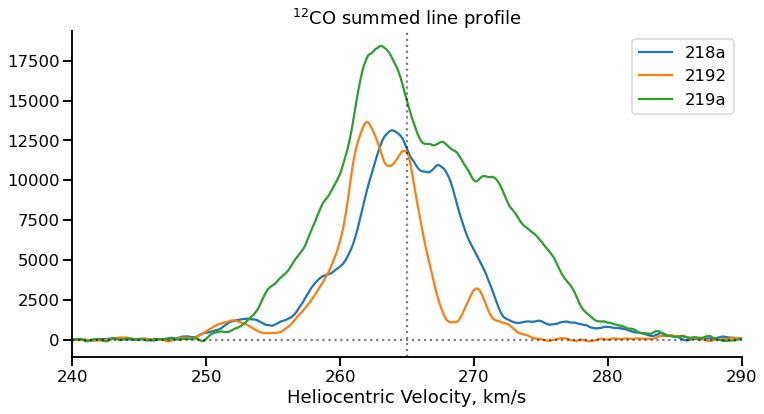

In [161]:
fig, ax = plt.subplots(figsize=(12,6))
for label, db in data_12co.items():
    vels = db["vels"] + VHEL
    spec = db["spec"]
    ax.plot(vels, spec, label=label)
ax.axvline(265.0, color="k", alpha=0.5, linestyle="dotted")
ax.axhline(0.0, color="k", alpha=0.5, linestyle="dotted")
ax.legend()
ax.set(
#    xlim=[700, 1400],
    xlim=[240, 290],
    xlabel="Heliocentric Velocity, km/s",
)
ax.set_title("$^{12}$CO summed line profile")
sns.despine();

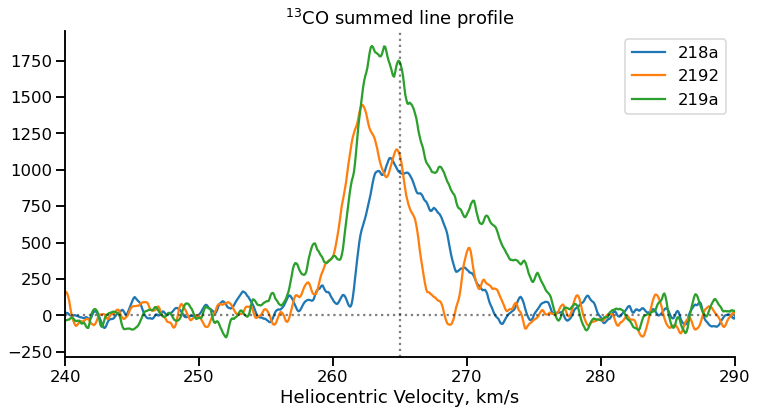

In [162]:
fig, ax = plt.subplots(figsize=(12,6))
for label, db in data_13co.items():
    vels = db["vels"] + VHEL
    spec = db["spec"]
    ax.plot(vels, spec, label=label)
ax.axvline(265.0, color="k", alpha=0.5, linestyle="dotted")
ax.axhline(0.0, color="k", alpha=0.5, linestyle="dotted")
ax.legend()
ax.set(
#    xlim=[700, 1400],
    xlim=[240, 290],
    xlabel="Heliocentric Velocity, km/s",
)
ax.set_title("$^{13}$CO summed line profile")
sns.despine();

In [164]:
for db in data_13co.values():
    db["specm"] = np.nanmax(db["hdu"].data[0, ...], axis=(1, 2))

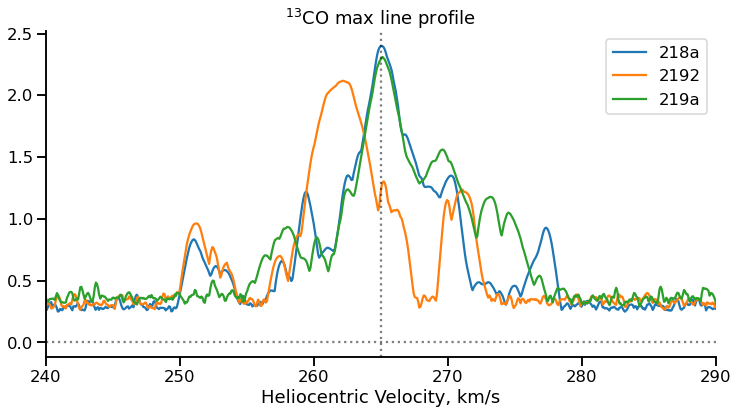

In [168]:
fig, ax = plt.subplots(figsize=(12,6))
for label, db in data_13co.items():
    vels = db["vels"] + VHEL
    spec = db["specm"]
    ax.plot(vels, spec, label=label)
ax.axvline(265.0, color="k", alpha=0.5, linestyle="dotted")
ax.axhline(0.0, color="k", alpha=0.5, linestyle="dotted")
ax.legend()
ax.set(
#    xlim=[700, 1400],
    xlim=[240, 290],
    xlabel="Heliocentric Velocity, km/s",
)
ax.set_title("$^{13}$CO max line profile")
sns.despine();

In [167]:
data_13co["218a"]["vels"]

array([337.89905323, 337.81602675, 337.73300028, ..., 179.06940831,
       178.98638184, 178.90335536])

In [169]:
for db in data_12co.values():
    db["specm"] = np.nanmax(db["hdu"].data[0, ...], axis=(1, 2))

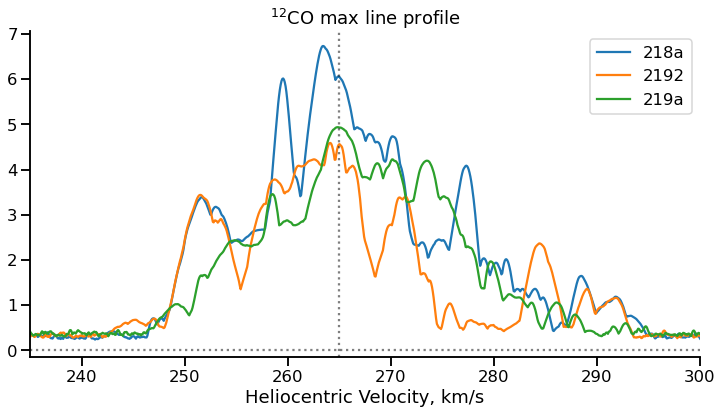

In [172]:
fig, ax = plt.subplots(figsize=(12,6))
for label, db in data_12co.items():
    vels = db["vels"] + VHEL
    spec = db["specm"]
    ax.plot(vels, spec, label=label)
ax.axvline(265.0, color="k", alpha=0.5, linestyle="dotted")
ax.axhline(0.0, color="k", alpha=0.5, linestyle="dotted")
ax.legend()
ax.set(
#    xlim=[700, 1400],
    xlim=[235, 300],
    xlabel="Heliocentric Velocity, km/s",
)
ax.set_title("$^{12}$CO max line profile")
sns.despine();

### Now compare with the mean velocities

In [173]:
import pandas as pd

<ipython-input-265-685a0a7444fa>:8: RuntimeWarning: invalid value encountered in log10
  db["log sum"] = np.log10(db["sum"])


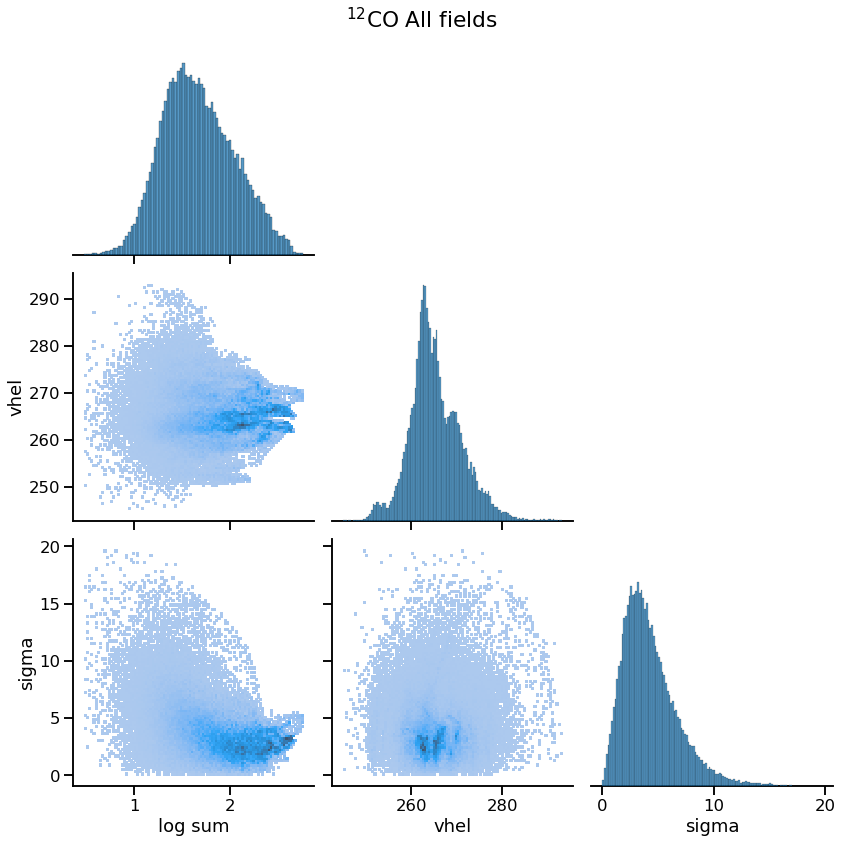

In [265]:
_vars = ["sum", "log sum", "peak08", "vhel", "sigma"]

d = {q: [] for q in _vars}

for db in data_12co.values():
#for db in [data_12co["219a"]]:
    db["vhel"] = db["vmean"] + VHEL
    db["log sum"] = np.log10(db["sum"])
    m = np.isfinite(db["vhel"]) & (db["peak08"] > 0.5) 
    m = m & (db["sum"] > 3.0)
    m = m & (db["vhel"] > 220.0) & (db["vhel"] < 330.0)
    m = m & (db["sigma"] < 20.0)
    for q in _vars:
        d[q].extend(list(db[q][m]))

df = pd.DataFrame(d)

g = sns.pairplot(
    df,
    vars=["log sum", "vhel", "sigma"],
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=df["sum"],
        bins=100,
    ),
)
g.fig.suptitle("$^{12}$CO All fields");

<ipython-input-266-061e40a4e515>:6: RuntimeWarning: invalid value encountered in log10
  db["log sum"] = np.log10(db["sum"])


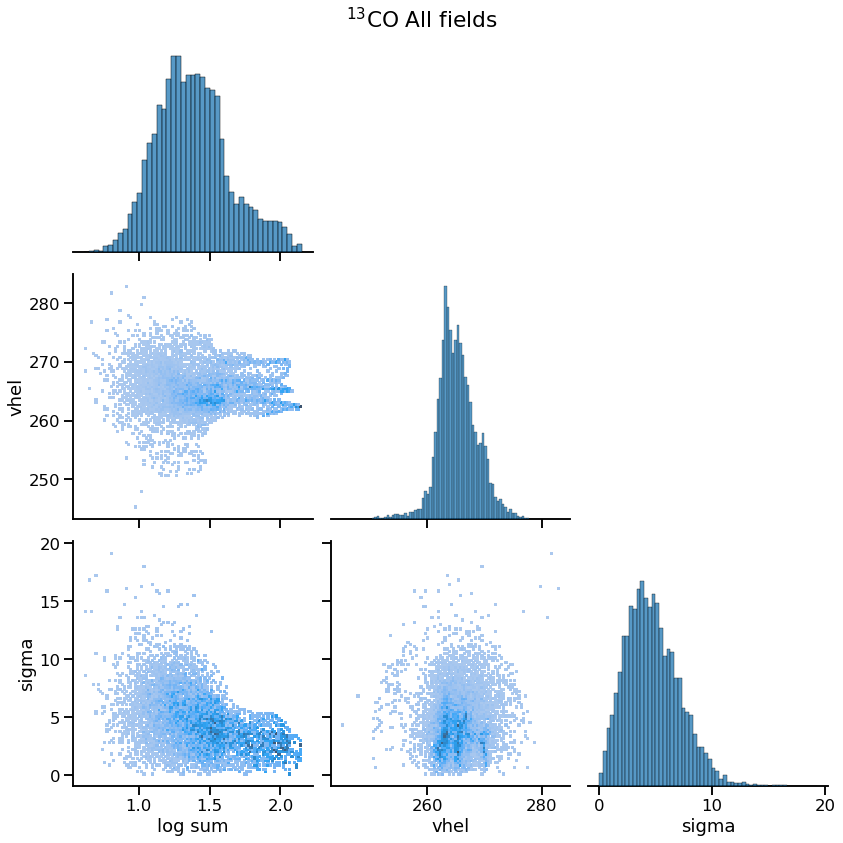

In [266]:
d = {q: [] for q in _vars}

for db in data_13co.values():
#for db in [data_12co["219a"]]:
    db["vhel"] = db["vmean"] + VHEL
    db["log sum"] = np.log10(db["sum"])
    m = np.isfinite(db["vhel"]) & (db["peak08"] > 0.5) 
    m = m & (db["sum"] > 3.0)
    m = m & (db["vhel"] > 220.0) & (db["vhel"] < 330.0)
    m = m & (db["sigma"] < 20.0)
    for q in _vars:
        d[q].extend(list(db[q][m]))

df = pd.DataFrame(d)

g = sns.pairplot(
    df,
    vars=["log sum", "vhel", "sigma"],
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=df["sum"],
        bins=100,
    ),
)
g.fig.suptitle("$^{13}$CO All fields");

### Calculate distance from center

In [267]:
from astropy.coordinates import SkyCoord

In [270]:
c0 = SkyCoord("5:38:41.3616 -69:06:03.254", unit=(u.hourangle, u.deg))
c0

<SkyCoord (ICRS): (ra, dec) in deg
    (84.67234, -69.10090389)>

In [279]:
for field in data_12co:
    db = data_12co[field]
    ny, nx = db["sum"].shape
    w = db["wcs"]
    X, Y = np.meshgrid(np.arange(nx), np.arange(ny))
    c = w.pixel_to_world(X, Y)
    s = c0.separation(c)
    # print(s.arcsec.min(), s.arcsec.max())
    db["radius"] = s.arcsec
    data_13co[field]["radius"] = s.arcsec

<ipython-input-305-55b5063a93e9>:8: RuntimeWarning: invalid value encountered in log10
  db["log sum"] = np.log10(db["sum"])


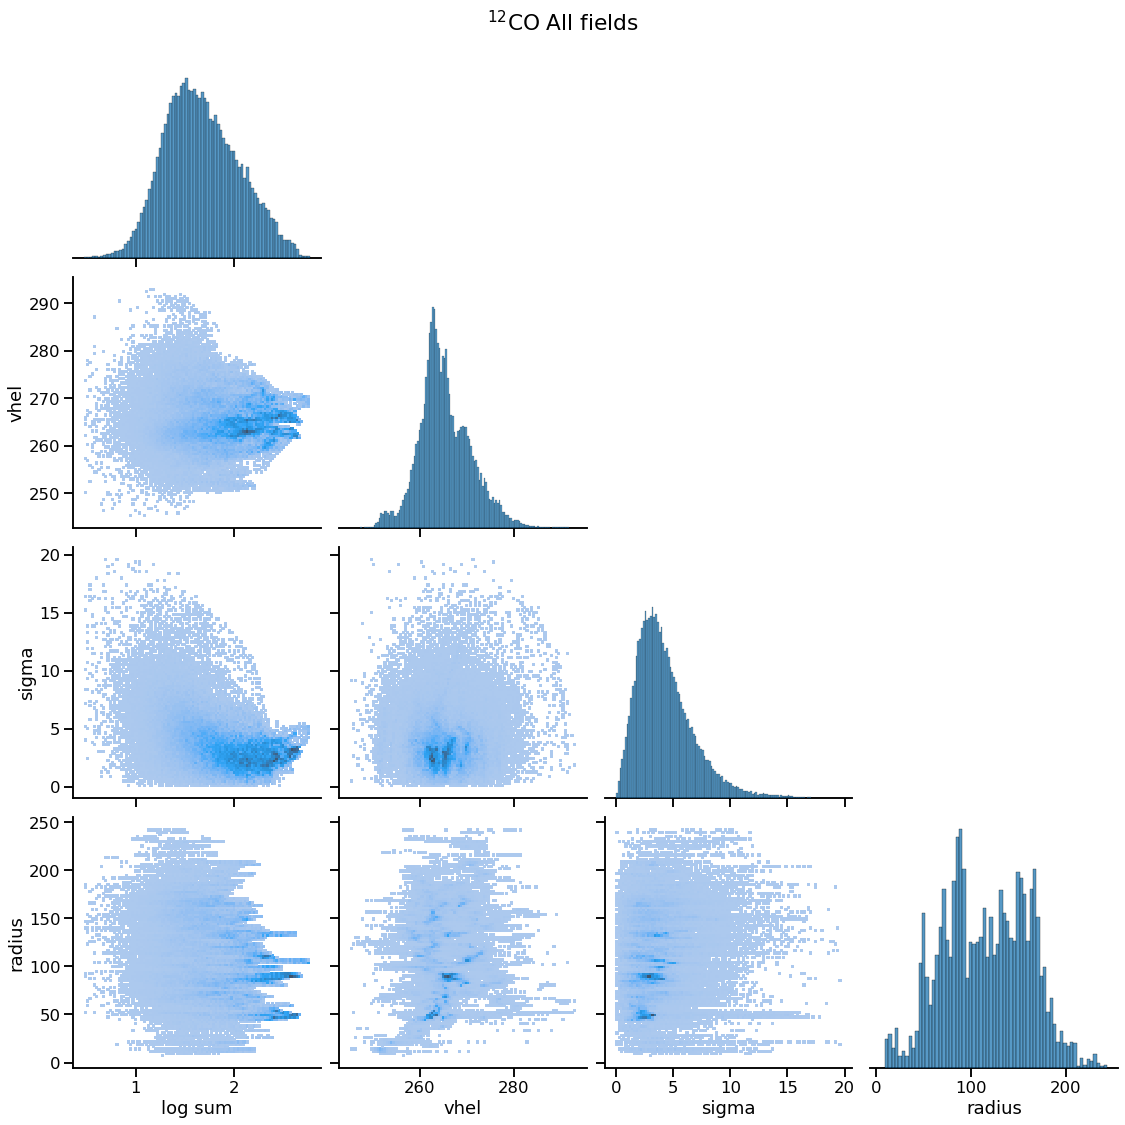

In [305]:
_vars = ["sum", "log sum", "peak08", "vhel", "sigma", "radius"]

d = {q: [] for q in _vars}

for db in data_12co.values():
#for db in [data_12co["219a"]]:
    db["vhel"] = db["vmean"] + VHEL
    db["log sum"] = np.log10(db["sum"])
    m = np.isfinite(db["vhel"]) & (db["peak08"] > 0.5) 
    m = m & (db["sum"] > 3.0)
    m = m & (db["vhel"] > 220.0) & (db["vhel"] < 330.0)
    m = m & (db["sigma"] < 20.0)
    for q in _vars:
        d[q].extend(list(db[q][m]))

df = pd.DataFrame(d)

g = sns.pairplot(
    df,
    vars=["log sum", "vhel", "sigma", "radius"],
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=df["sum"],
        bins=100,
    ),
)
g.fig.suptitle("$^{12}$CO All fields");

In [303]:
from corner import corner

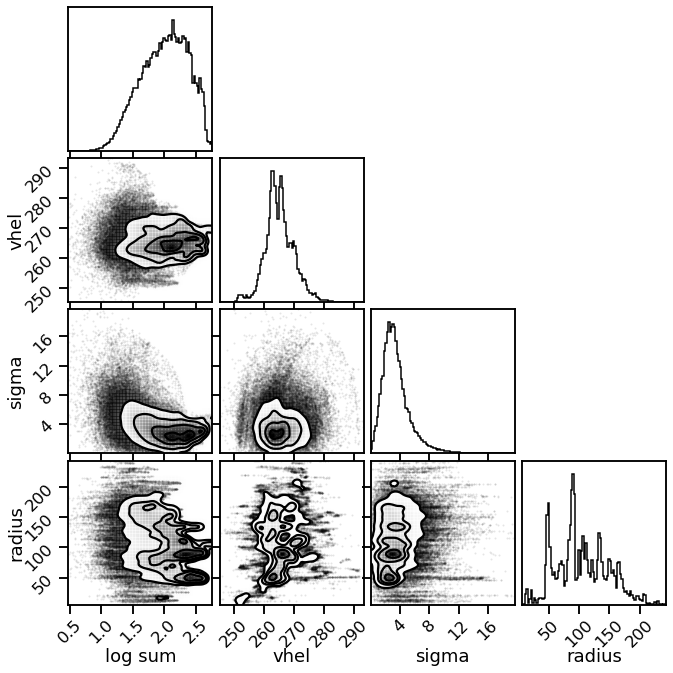

In [306]:
corner(
    df, 
    var_names=["log sum", "vhel", "sigma", "radius"], 
    weights=df["sum"], 
    bins=100, 
    plot_contours=True,
    smooth=2.0,
    linewidth=0.3,
);

<ipython-input-282-9df3006ebec8>:8: RuntimeWarning: invalid value encountered in log10
  db["log sum"] = np.log10(db["sum"])


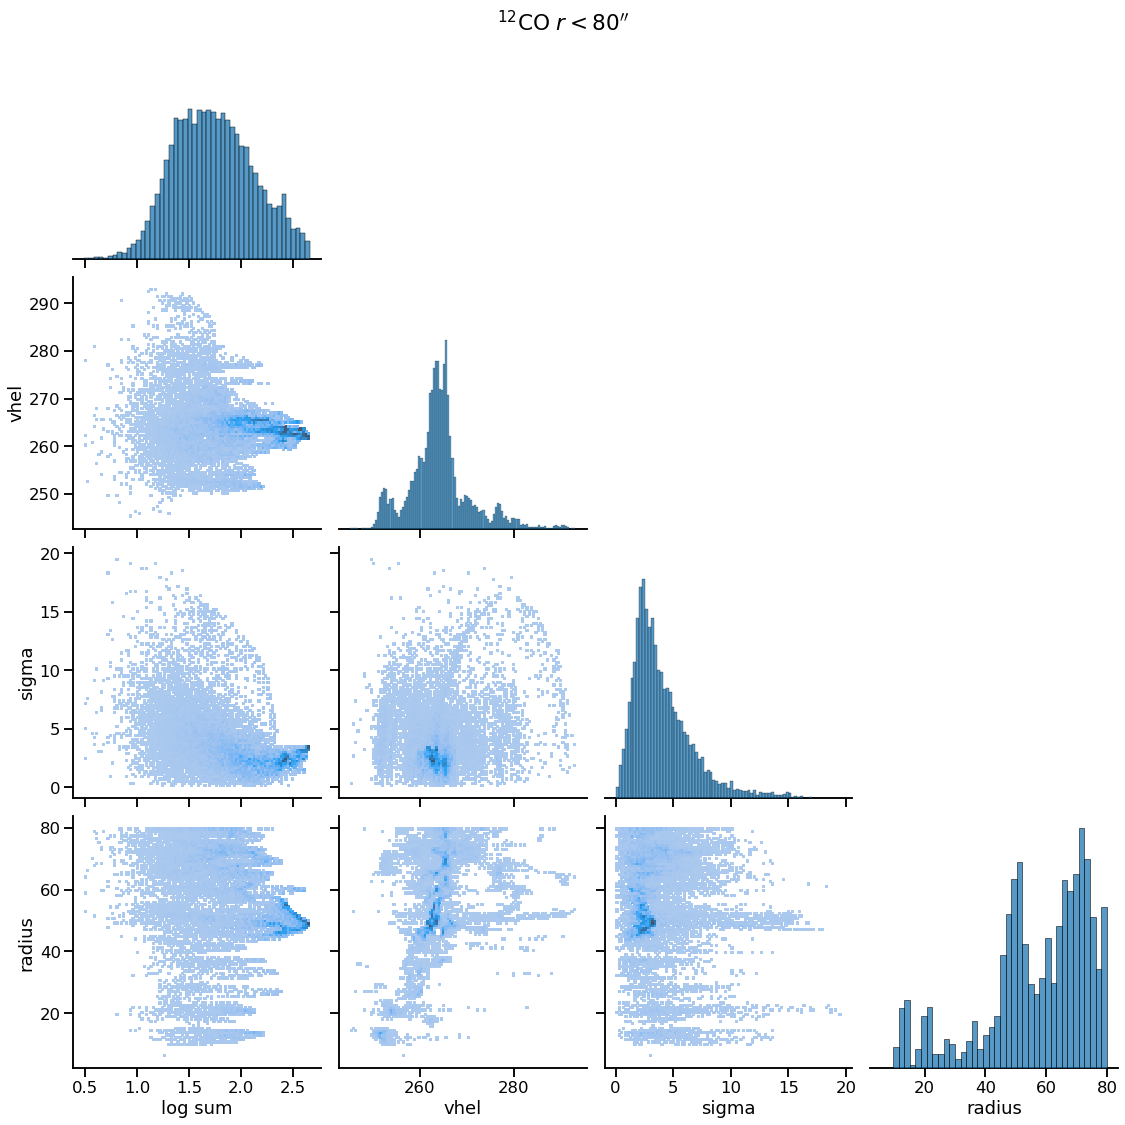

In [282]:
_vars = ["sum", "log sum", "peak08", "vhel", "sigma", "radius"]

d = {q: [] for q in _vars}

for db in data_12co.values():
#for db in [data_12co["219a"]]:
    db["vhel"] = db["vmean"] + VHEL
    db["log sum"] = np.log10(db["sum"])
    m = np.isfinite(db["vhel"]) & (db["peak08"] > 0.5) 
    m = m & (db["sum"] > 3.0)
    m = m & (db["vhel"] > 220.0) & (db["vhel"] < 330.0)
    m = m & (db["sigma"] < 20.0)
    m = m & (db["radius"] < 80.0)
    for q in _vars:
        d[q].extend(list(db[q][m]))

df = pd.DataFrame(d)

g = sns.pairplot(
    df,
    vars=["log sum", "vhel", "sigma", "radius"],
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(
        weights=df["sum"],
        bins=100,
    ),
)
g.fig.suptitle("$^{12}$CO $r < 80''$");

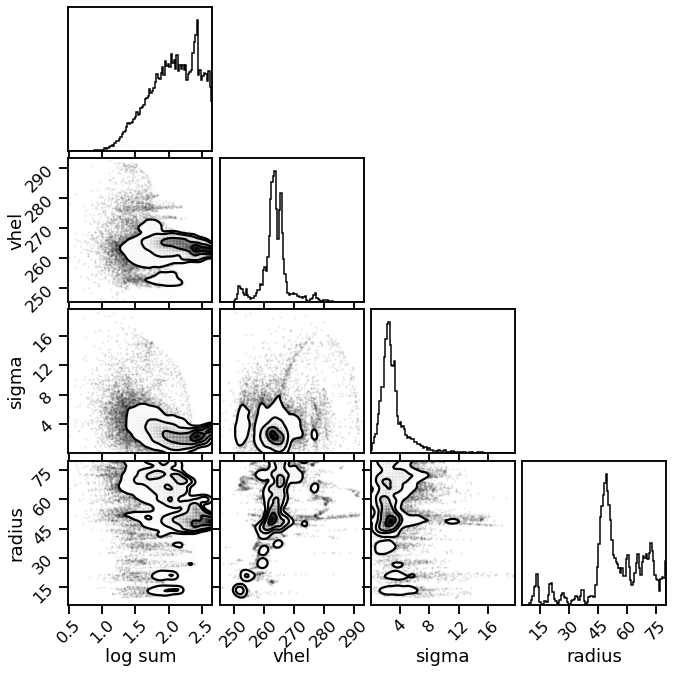

In [302]:
corner(
    df, 
    var_names=["log sum", "vhel", "sigma", "radius"], 
    weights=df["sum"], 
    bins=100, 
    plot_contours=True,
    smooth=2.0,
    linewidth=0.3,
);

We see a clear gradient of velocity with radius!